<div style="display: flex; background-color: RGB(255,114,0); padding: 30px;" >

# <font color='black'> # Analyse de sentiments </font>

</div>


C'est désormais un problème classique de machine learning. D'un côté, du texte, de l'autre une appréciation, le plus souvent binaire, positive ou négative mais qui pourrait être graduelle.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from os import getcwd
import matplotlib.image as mpimg
import nltk
from nltk.corpus import stopwords, wordnet
from IPython.core.display import HTML
from collections import Counter
from sklearn.metrics import confusion_matrix


In [2]:
import sys
sys.path.append("C:\\Users\\User\\WORK\\workspace-ia\\PERSO\\")
from ara_commons import ara_nlp_function as ara_nlp
from ara_commons.ara_graph import color_graph_background
from ara_commons.ara_df import get_numeric_columns_names, process_one_hot

In [3]:
# ---------------------------------------------------------------------------------------------
#                               MAIN
# ---------------------------------------------------------------------------------------------
verbose = False
verboseMain = False

# Récupère le répertoire du programme
file_path = getcwd() + "\\"
file_path

'c:\\Users\\User\\WORK\\workspace-ia\\simplon\\2022-02-NLP-Sentiments-analyses\\'

<div style="display: flex; background-color: Blue; padding: 15px;" >

## Les données
</div>

On récupère les données depuis le site UCI [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences). 

Il y a trois fichiers textes à importer et à concaténer pour former un dataset avec deux colonnes:
- Une "texte" comportant le contenu du commentaire
- Une "sentiment" comportant une note de 0 ou 1

In [4]:
print("Chargement des données...")
file_name_amazon_label = "amazon_cells_labelled.txt"
file_name_imdb_labelled = "imdb_labelled.txt"
file_name_yelp_labelled = 'yelp_labelled.txt'

df_origin_amazon_label = pd.read_csv(file_path+"\\data\\"+file_name_amazon_label, sep='\t', header=None)
# Forcer le séparateur, sinon il manque des données, on précise que l'on veut un séparateur suivi d'un 0 ou 1
df_origin_imdb_labelled = pd.read_csv(file_path+"\\data\\"+file_name_imdb_labelled, sep='\t(0|1)', header=None)
df_origin_yelp_labelled= pd.read_csv(file_path+"\\data\\"+file_name_yelp_labelled, sep='\t', header=None)

print("Chargement des données", df_origin_amazon_label.shape, df_origin_imdb_labelled.shape,  df_origin_yelp_labelled.shape, ".......................................... END")

Chargement des données...
Chargement des données (1000, 2) (1000, 3) (1000, 2) .......................................... END


In [5]:
# df_origin_imdb_labelled a une colonne de trop
print(df_origin_imdb_labelled.columns)
df_origin_imdb_labelled.head()

Int64Index([0, 1, 2], dtype='int64')


,0,1,2
0,"A very, very, very slow-moving, aimless movie ...",0,NaN
1,Not sure who was more lost - the flat characte...,0,NaN
2,Attempting artiness with black & white and cle...,0,NaN
3,Very little music or anything to speak of.,0,NaN
4,The best scene in the movie was when Gerardo i...,1,NaN


In [6]:
df_origin_imdb_labelled = df_origin_imdb_labelled.drop(2, axis=1)
df_origin_imdb_labelled.head()

,0,1
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [7]:
df_origin_amazon_label.head()

,0,1
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [8]:
df_origin_amazon_label["website"] = "amazon"
df_origin_imdb_labelled["website"] = "imdb"
df_origin_yelp_labelled["website"] = "yelp"

In [9]:
df_origin_full = df_origin_amazon_label.append(df_origin_imdb_labelled)
df_origin_full = df_origin_full.append(df_origin_yelp_labelled)
print(df_origin_full.shape)
df_origin_full.head()

(3000, 3)


,0,1,website
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon


In [10]:
df_origin_full = df_origin_full.rename(columns={0: "sentence", 1: "connotation"})
df_origin_full.columns

Index(['sentence', 'connotation', 'website'], dtype='object')

<div style="display: flex; background-color: Blue; padding: 15px;" >

## Exploration des données: 
</div>

<div style="display: flex; background-color: Green; padding: 7px;" >

### Questions préalables: 
</div>

- Quelle est la taille du dataset ?
- Comment est distribuée la variable sentiment ?

In [11]:
df_origin_full.shape

(3000, 3)

In [12]:
df_origin_full["connotation"].value_counts()

0    1500
1    1500
Name: connotation, dtype: int64

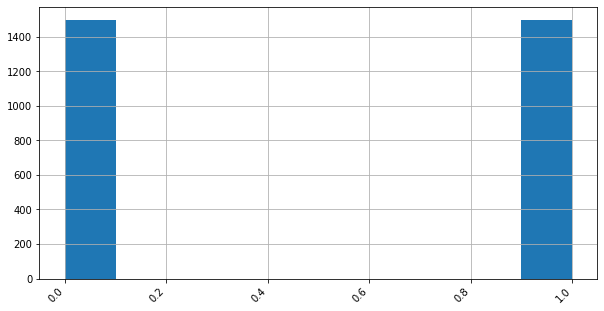

In [13]:
figure, axes = color_graph_background(1, 1)

df_origin_full.connotation.hist()

figure.set_size_inches(10, 5, forward=True)
plt.xticks(rotation=45, ha="right")
plt.show()

In [14]:
df_origin_full.columns

Index(['sentence', 'connotation', 'website'], dtype='object')

In [15]:
df_origin_full["connotation_label"] = np.nan
df_origin_full.loc[df_origin_full['connotation'] == 0, 'connotation_label'] = "negativ"
df_origin_full.loc[df_origin_full['connotation'] == 1, 'connotation_label'] = "positiv"
df_origin_full

,sentence,connotation,website,connotation_label
0,So there is no way for me to plug it in here i...,0,amazon,negativ
1,"Good case, Excellent value.",1,amazon,positiv
2,Great for the jawbone.,1,amazon,positiv
3,Tied to charger for conversations lasting more...,0,amazon,negativ
4,The mic is great.,1,amazon,positiv
...,...,...,...,...
995,I think food should have flavor and texture an...,0,yelp,negativ
996,Appetite instantly gone.,0,yelp,negativ
997,Overall I was not impressed and would not go b...,0,yelp,negativ
998,"The whole experience was underwhelming, and I ...",0,yelp,negativ


In [16]:
df_group = df_origin_full.groupby(["website", "connotation_label"], as_index=True)['connotation'].count()
df_group

website  connotation_label
amazon   negativ              500
         positiv              500
imdb     negativ              500
         positiv              500
yelp     negativ              500
         positiv              500
Name: connotation, dtype: int64

In [17]:
df_group_ri = df_group.reset_index()
df_group_ri

,website,connotation_label,connotation
0,amazon,negativ,500
1,amazon,positiv,500
2,imdb,negativ,500
3,imdb,positiv,500
4,yelp,negativ,500
5,yelp,positiv,500


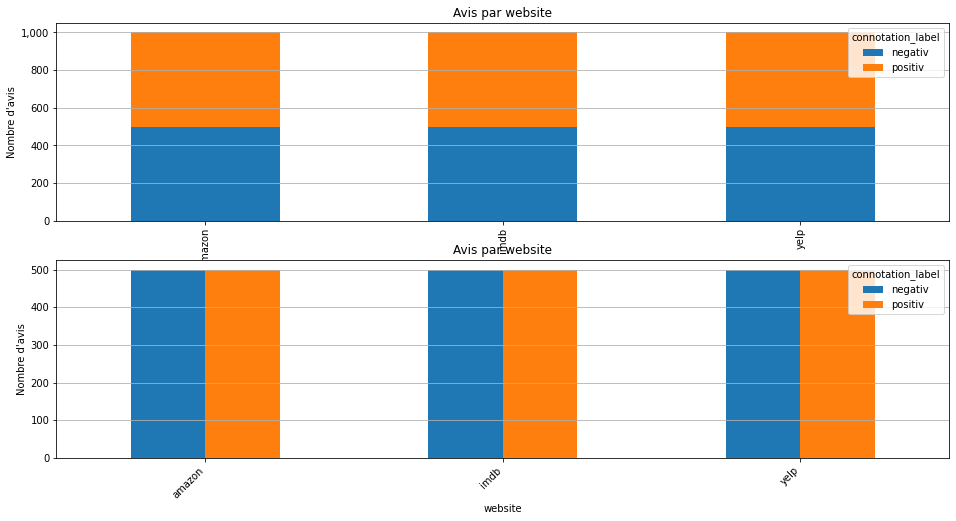

In [18]:
df_group = df_origin_full.groupby(["website", "connotation_label"])['connotation'].count().unstack('connotation_label').fillna(0)
figure, axes = color_graph_background(2, 1)

axe = axes[0]
df_group.plot(kind='bar', stacked=True, title="Avis par website", ax=axe)
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f}". format(x)))
axe.set_ylabel("Nombre d'avis")
axe.grid(axis='y')

axe = axes[1]
df_group.plot(kind='bar', stacked=False, title="Avis par website", ax=axe)
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f}". format(x)))
axe.set_ylabel("Nombre d'avis")
axe.grid(axis='y')

figure.set_size_inches(16, 8, forward=True)
plt.xticks(rotation=45, ha="right")
plt.show()

In [19]:
df_origin_full = df_origin_full.reset_index()
df_origin_full = df_origin_full.drop("index", axis=1)
df_origin_full.head()

,sentence,connotation,website,connotation_label
0,So there is no way for me to plug it in here i...,0,amazon,negativ
1,"Good case, Excellent value.",1,amazon,positiv
2,Great for the jawbone.,1,amazon,positiv
3,Tied to charger for conversations lasting more...,0,amazon,negativ
4,The mic is great.,1,amazon,positiv


In [20]:
target = 'connotation'

<div style="display: flex; background-color: Blue; padding: 15px;" >

## Pré-processing
</div>

<div style="display: flex; background-color: Green; padding: 7px;" >

### Question 1: Combien y a t'il de mots dans l'ensemble du corpus ? Sont-ils "homogènes" ? 
</div>

### Import du module permettant le traitement de texte: nltk

In [21]:
print(df_origin_full.shape)
df_origin_full.columns

(3000, 4)


Index(['sentence', 'connotation', 'website', 'connotation_label'], dtype='object')

In [22]:
df_nlp = df_origin_full[['website','connotation_label', 'connotation', 'sentence']]
print(df_nlp.shape)
print(df_nlp.columns)
df_nlp

(3000, 4)
Index(['website', 'connotation_label', 'connotation', 'sentence'], dtype='object')


,website,connotation_label,connotation,sentence
0,amazon,negativ,0,So there is no way for me to plug it in here i...
1,amazon,positiv,1,"Good case, Excellent value."
2,amazon,positiv,1,Great for the jawbone.
3,amazon,negativ,0,Tied to charger for conversations lasting more...
4,amazon,positiv,1,The mic is great.
...,...,...,...,...
2995,yelp,negativ,0,I think food should have flavor and texture an...
2996,yelp,negativ,0,Appetite instantly gone.
2997,yelp,negativ,0,Overall I was not impressed and would not go b...
2998,yelp,negativ,0,"The whole experience was underwhelming, and I ..."


In [134]:
def nlp_pre_process(input, string_expected=True, sw=None, sw_language=None, ngram=(1,1), verbose=0):
    res = []
    # ce traitement n'est fait qu'une fois, même si l'on appelle en récurcif la méthode
    # if sw_language :
    #     if sw is None:
    #         sw = stopwords.words(sw_language)
    #     else :
    #         sw.extend(stopwords.words(sw_language))
    if isinstance(input, list):
        res = [' '.join(nlp_pre_process(sentence, string_expected=string_expected, sw=sw, ngram=ngram)) for sentence in input]
    elif isinstance(input, str):
        res = ara_nlp.ara_tokenize(input)
        # res = ara_nlp.remove_english_stopwords_func(res, sw)
        # res = ara_nlp.normalize_accented_chars(res)
        # res = ara_nlp.remove_irr_char_func(res)
        # res = ara_nlp.norm_lemm_a_func(res, is_text_list=True)
        # res = ara_nlp.remove_types_on_tokens(res, types_to_keep=[wordnet.ADJ,wordnet.NOUN], verbose=verbose)
        # res = ara_nlp.norm_lemm_func(res, auto_type=True, is_text_list=True)
        # res = ara_nlp.remove_types_on_tokens(res, types_to_keep=[wordnet.ADJ,wordnet.NOUN], verbose=verbose)
        # res = ara_nlp.remove_english_stopwords_func(res, sw)
        # if ngram is not None and (ngram[0] > 1 or ngram[1]>1):
        #     res = ara_nlp.ara_ngrams(res, min_n=ngram[0], max_n=ngram[1], pas_n=1, verbose=verbose, is_token=True)
    res = list(filter(None, res))
    if string_expected:
        res = ' '.join(res)
    return res

In [ ]:
def nlp_pre_process_hight_process(input, string_expected=True, sw=None, sw_language=None, ngram=(1,1), verbose=0):
    res = []
    # ce traitement n'est fait qu'une fois, même si l'on appelle en récurcif la méthode
    if sw_language :
        if sw is None:
            sw = stopwords.words(sw_language)
        else :
            sw.extend(stopwords.words(sw_language))

    if isinstance(input, list):
        res = [' '.join(nlp_pre_process(sentence, string_expected=string_expected, sw=sw, ngram=ngram)) for sentence in input]
    elif isinstance(input, str):
        res = ara_nlp.ara_tokenize(input)
        res = ara_nlp.remove_english_stopwords_func(res, sw)
        res = ara_nlp.normalize_accented_chars(res)
        res = ara_nlp.remove_irr_char_func(res)
        # res = ara_nlp.norm_lemm_a_func(res, is_text_list=True)
        # res = ara_nlp.remove_types_on_tokens(res, types_to_keep=[wordnet.ADJ,wordnet.NOUN], verbose=verbose)
        res = ara_nlp.norm_lemm_func(res, auto_type=True, is_text_list=True)
        # res = ara_nlp.remove_types_on_tokens(res, types_to_keep=[wordnet.ADJ,wordnet.NOUN], verbose=verbose)
        res = ara_nlp.remove_english_stopwords_func(res, sw)
        if ngram is not None and (ngram[0] > 1 or ngram[1]>1):
            res = ara_nlp.ara_ngrams(res, min_n=ngram[0], max_n=ngram[1], pas_n=1, verbose=verbose, is_token=True)
    res = list(filter(None, res))
    if string_expected:
        res = ' '.join(res)
    return res

#### Consigne 1: Récupérer le corpus de mots sans la ponctuation ni les stopwords

In [135]:
personnal_stop_word = []

In [136]:
df_nlp["words"] = df_nlp["sentence"].apply(lambda x: nlp_pre_process(x, string_expected=False, sw=personnal_stop_word, sw_language="english"))
df_nlp["sentence_clean"] = df_nlp["words"].apply(lambda x: " ".join(x))
display(HTML(df_nlp.head().to_html()))

,website,connotation_label,connotation,sentence,words,sentence_clean,nb_old_words,nb_words
0,amazon,negativ,0,So there is no way for me to plug it in here in the US unless I go by a converter.,"[so, there, is, no, way, for, me, to, plug, it, in, here, in, the, us, unless, i, go, by, a, converter]",so there is no way for me to plug it in here in the us unless i go by a converter,21,21
1,amazon,positiv,1,"Good case, Excellent value.","[good, case, excellent, value]",good case excellent value,4,4
2,amazon,positiv,1,Great for the jawbone.,"[great, for, the, jawbone]",great for the jawbone,4,4
3,amazon,negativ,0,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,"[tied, to, charger, for, conversations, lasting, more, than, 45, minutes, major, problems]",tied to charger for conversations lasting more than 45 minutes major problems,11,11
4,amazon,positiv,1,The mic is great.,"[the, mic, is, great]",the mic is great,4,4


In [102]:
df_nlp.isna().sum()

website              0
connotation_label    0
connotation          0
sentence             0
words                0
sentence_clean       0
nb_old_words         0
nb_words             0
dtype: int64

In [103]:
df_nlp.describe()

,connotation,nb_old_words,nb_words
count,3000.000000,3000.000000,3000.000000
mean,0.500000,11.831667,6.003333
std,0.500083,7.872441,4.130901
min,0.000000,1.000000,0.000000
25%,0.000000,6.000000,3.000000
50%,0.500000,10.000000,5.000000
75%,1.000000,16.000000,8.000000
max,1.000000,71.000000,44.000000


<div style="display: flex; background-color: Green; padding: 7px;" >

### Question 2: Combien de mots restent-ils ? 
</div>

In [137]:
df_nlp["nb_old_words"] = df_nlp["sentence"].apply(lambda x: len(x.split()))
df_nlp["nb_words"] = df_nlp["words"].apply(lambda x: len(x))

In [138]:
df_nlp[df_nlp["nb_words"]==0]

,website,connotation_label,connotation,sentence,words,sentence_clean,nb_old_words,nb_words


In [139]:
display(HTML(df_nlp.head(20).to_html()))

,website,connotation_label,connotation,sentence,words,sentence_clean,nb_old_words,nb_words
0,amazon,negativ,0,So there is no way for me to plug it in here in the US unless I go by a converter.,"[so, there, is, no, way, for, me, to, plug, it, in, here, in, the, us, unless, i, go, by, a, converter]",so there is no way for me to plug it in here in the us unless i go by a converter,21,21
1,amazon,positiv,1,"Good case, Excellent value.","[good, case, excellent, value]",good case excellent value,4,4
2,amazon,positiv,1,Great for the jawbone.,"[great, for, the, jawbone]",great for the jawbone,4,4
3,amazon,negativ,0,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,"[tied, to, charger, for, conversations, lasting, more, than, 45, minutes, major, problems]",tied to charger for conversations lasting more than 45 minutes major problems,11,12
4,amazon,positiv,1,The mic is great.,"[the, mic, is, great]",the mic is great,4,4
5,amazon,negativ,0,I have to jiggle the plug to get it to line up right to get decent volume.,"[i, have, to, jiggle, the, plug, to, get, it, to, line, up, right, to, get, decent, volume]",i have to jiggle the plug to get it to line up right to get decent volume,17,17
6,amazon,negativ,0,"If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.","[if, you, have, several, dozen, or, several, hundred, contacts, then, imagine, the, fun, of, sending, each, of, them, one, by, one]",if you have several dozen or several hundred contacts then imagine the fun of sending each of them one by one,21,21
7,amazon,positiv,1,If you are Razr owner...you must have this!,"[if, you, are, razr, owner, you, must, have, this]",if you are razr owner you must have this,8,9
8,amazon,negativ,0,"Needless to say, I wasted my money.","[needless, to, say, i, wasted, my, money]",needless to say i wasted my money,7,7
9,amazon,negativ,0,What a waste of money and time!.,"[what, a, waste, of, money, and, time]",what a waste of money and time,7,7


<mark> Attention : les négations ont disparue, ce qui change le sens des phrases</mark>

In [140]:
nb_old_w = df_nlp["nb_old_words"].sum()
nb_w = df_nlp["nb_words"].sum()
print(f"nb_old_words : {nb_old_w}, nb_words : {nb_w}")

nb_old_words : 35495, nb_words : 36375


Graphe général

36114 words


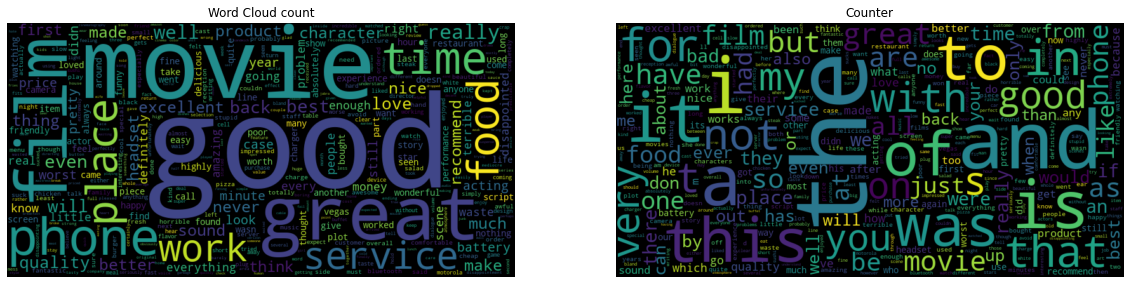

In [108]:
fig, ax = color_graph_background(1,2)

temp = list(df_nlp["words"])
ing_list = []
for igs in temp:
    for ig in igs:
        ing_list.append(ig)
if verbose:
    print(ing_list)
print(len(ing_list), "words")
ara_nlp.draw_word_cloud(ing_list, ax=ax[0])
ax[0].set_title("Word Cloud count")

dict_texte = dict(Counter(ing_list).most_common())
ara_nlp.draw_word_cloud(texte=dict_texte, ax=ax[1])
ax[1].set_title("Counter")

fig.set_size_inches(20, 15, forward=True)
plt.show()


Graphe par site web

In [141]:
websites = df_nlp["website"].unique()
websites

array(['amazon', 'imdb', 'yelp'], dtype=object)

10470 words for  amazon
14791 words for  imdb
11114 words for  yelp


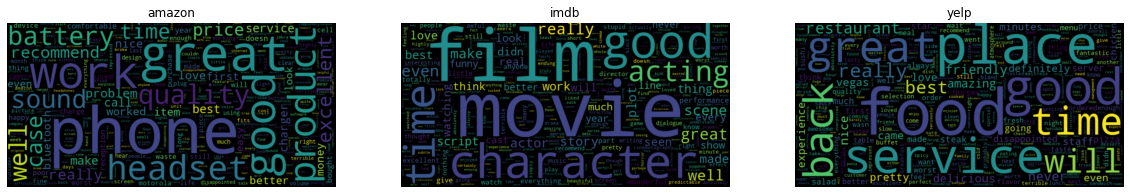

In [142]:
fig, ax = color_graph_background(1,len(websites))

i = 0
for site in websites:
    temp = list(df_nlp.loc[df_nlp["website"]==site,"words"])
    ing_list = []
    for igs in temp:
        for ig in igs:
            ing_list.append(ig)
    if verbose:
        print(ing_list)
    print(len(ing_list), "words for ", site)
    ara_nlp.draw_word_cloud(ing_list, ax=ax[i])
    ax[i].set_title(site)
    i += 1

fig.set_size_inches(20, 15, forward=True)
# plt.xticks(rotation=45, ha="right")
plt.show()

<div style="display: flex; background-color: Green; padding: 7px;" >

### Using NLTK’s Pre-Trained Sentiment Analyzer
</div>

In [143]:
df_nlp.columns

Index(['website', 'connotation_label', 'connotation', 'sentence', 'words',
       'sentence_clean', 'nb_old_words', 'nb_words'],
      dtype='object')

In [144]:
df_nlp_sia = df_nlp[['website', 'connotation_label', 'connotation', 'sentence', 'words', 'sentence_clean', 'nb_words']]
df_nlp_sia

,website,connotation_label,connotation,sentence,words,sentence_clean,nb_words
0,amazon,negativ,0,So there is no way for me to plug it in here i...,"[so, there, is, no, way, for, me, to, plug, it...",so there is no way for me to plug it in here i...,21
1,amazon,positiv,1,"Good case, Excellent value.","[good, case, excellent, value]",good case excellent value,4
2,amazon,positiv,1,Great for the jawbone.,"[great, for, the, jawbone]",great for the jawbone,4
3,amazon,negativ,0,Tied to charger for conversations lasting more...,"[tied, to, charger, for, conversations, lastin...",tied to charger for conversations lasting more...,12
4,amazon,positiv,1,The mic is great.,"[the, mic, is, great]",the mic is great,4
...,...,...,...,...,...,...,...
2995,yelp,negativ,0,I think food should have flavor and texture an...,"[i, think, food, should, have, flavor, and, te...",i think food should have flavor and texture an...,12
2996,yelp,negativ,0,Appetite instantly gone.,"[appetite, instantly, gone]",appetite instantly gone,3
2997,yelp,negativ,0,Overall I was not impressed and would not go b...,"[overall, i, was, not, impressed, and, would, ...",overall i was not impressed and would not go back,10
2998,yelp,negativ,0,"The whole experience was underwhelming, and I ...","[the, whole, experience, was, underwhelming, a...",the whole experience was underwhelming and i t...,17


In [145]:
df_nlp_sia = ara_nlp.ara_polarity(df_nlp_sia, sentence_col_name='sentence', dest_col_name='src_polarity', verbose=1)

Accuracy = 0.673 soit 2020 found on 3000


In [112]:
df_nlp_sia = ara_nlp.ara_polarity(df_nlp_sia, sentence_col_name='sentence_clean', dest_col_name='clean_polarity', verbose=1)

Accuracy = 0.676 soit 2027 found on 3000


<div style="display: flex; background-color: Blue; padding: 15px;" >

# Exercice 1 : approche td-idf
</div>

La cible est la colonne *sentiment*, les deux autres colonnes sont les features. Il faudra utiliser les prétraitements [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [TF-IDF](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html). L'un d'entre eux n'est pas nécessaire depuis la version [0.20.0](http://scikit-learn.org/stable/whats_new.html#sklearn-preprocessing) de *scikit-learn*.

<div style="display: flex; background-color: Green; padding: 7px;" >

### Consigne 2: Utiliser OneHotEncoder ou CountVectorizer pour représenter les données sous forme d'une matrice contenant autant de colonnes que de mots dans le corpus
</div>

In [113]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

<div style="display: flex; background-color: Green; padding: 7px;" >

### Consigne 3: lancer un modèle de classification pour prédire les sentiments de 30% des observations
</div>

*   Séparer échantillon train / test
*   Entrainer un modèle de classification
*   Afficher la matrice de confusion
*   Calculer l'accuracy, la précision et le recall
*   Votre modèle est-il soumis à un overfitting ?

<div style="display: flex; background-color: Green; padding: 7px;" >

### Consigne 4: Utiliser TF-IDF pour représenter les données et relancer un modèle de classification
</div>

In [114]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [146]:
print(df_nlp.columns)
df_nlp.head()

Index(['website', 'connotation_label', 'connotation', 'sentence', 'words',
       'sentence_clean', 'nb_old_words', 'nb_words'],
      dtype='object')


,website,connotation_label,connotation,sentence,words,sentence_clean,nb_old_words,nb_words
0,amazon,negativ,0,So there is no way for me to plug it in here i...,"[so, there, is, no, way, for, me, to, plug, it...",so there is no way for me to plug it in here i...,21,21
1,amazon,positiv,1,"Good case, Excellent value.","[good, case, excellent, value]",good case excellent value,4,4
2,amazon,positiv,1,Great for the jawbone.,"[great, for, the, jawbone]",great for the jawbone,4,4
3,amazon,negativ,0,Tied to charger for conversations lasting more...,"[tied, to, charger, for, conversations, lastin...",tied to charger for conversations lasting more...,11,12
4,amazon,positiv,1,The mic is great.,"[the, mic, is, great]",the mic is great,4,4


<div style="display: flex; background-color: indigo;" >

#### Construction du vecteur et calcul du TF-IDF
</div>

In [147]:
vectorizer_idf_big = TfidfVectorizer(analyzer="word",token_pattern=ara_nlp.get_regex_tokens(), stop_words=personnal_stop_word, ngram_range = (1,3), max_features=400)
X = vectorizer_idf_big.fit_transform(df_nlp['sentence_clean'])
idf_big_df = pd.DataFrame(X.toarray(), index=df_nlp.index, columns=vectorizer_idf_big.get_feature_names_out())
# ajout du site web

# Réorganisation des colonnes pour la lecture
idf_full = pd.merge(df_nlp, idf_big_df, left_index=True, right_index=True)
idf_full = idf_full.drop(["nb_old_words", "connotation_label", "connotation"], axis=1)
# --
idf_full.head()

,website,sentence,words,sentence_clean,nb_words,1,10,2,5,a,...,work,worked,works,worst,worth,would,years,you,you can,your
0,amazon,So there is no way for me to plug it in here i...,"[so, there, is, no, way, for, me, to, plug, it...",so there is no way for me to plug it in here i...,21,0.0,0.0,0.0,0.0,0.130736,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,amazon,"Good case, Excellent value.","[good, case, excellent, value]",good case excellent value,4,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,amazon,Great for the jawbone.,"[great, for, the, jawbone]",great for the jawbone,4,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,amazon,Tied to charger for conversations lasting more...,"[tied, to, charger, for, conversations, lastin...",tied to charger for conversations lasting more...,12,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,amazon,The mic is great.,"[the, mic, is, great]",the mic is great,4,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:
idf_full.describe()

,nb_words,1,10,2,5,a,a few,a good,a great,a lot,...,work,worked,works,worst,worth,would,years,you,you can,your
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,12.125000,0.002861,0.004903,0.004784,0.002549,0.050848,0.002175,0.004761,0.006254,0.002588,...,0.006453,0.003088,0.008380,0.005265,0.003986,0.008692,0.002653,0.017896,0.002892,0.009071
std,8.107936,0.035449,0.052961,0.044857,0.035776,0.104943,0.027308,0.043902,0.052862,0.031467,...,0.049264,0.039748,0.068604,0.049227,0.044114,0.053405,0.029096,0.076337,0.033258,0.058764
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,74.000000,0.776692,1.000000,0.749719,0.706200,1.000000,0.554353,0.698557,0.759624,0.507544,...,0.625671,1.000000,0.895654,0.776498,0.806187,0.806402,0.471913,0.836234,0.636621,0.715028


In [118]:
max_words=200
voca = idf_big_df.T.sum(axis=1).sort_values(axis=0, ascending=False)
voca

good       97.770084
great      93.262535
movie      73.020163
film       71.301368
phone      71.001081
             ...    
face        4.433952
verizon     4.293123
ago         4.291837
effects     4.282122
decent      4.170630
Length: 400, dtype: float64

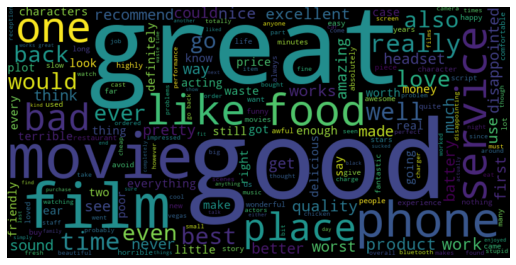

In [149]:
ara_nlp.draw_word_cloud(voca[0:max_words])

<div style="display: flex; background-color: indigo;" >

#### Prédiction
</div>

In [120]:
idf_full.head()

,website,sentence,words,sentence_clean,nb_words,absolutely,acting,actor,actors,actually,...,worse,worst,worth,would,would recommend,writing,wrong,year,years,yet
0,amazon,So there is no way for me to plug it in here i...,"[so, there, is, no, way, for, me, to, plug, it...",so there is no way for me to plug it in here i...,21,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,amazon,"Good case, Excellent value.","[good, case, excellent, value]",good case excellent value,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,amazon,Great for the jawbone.,"[great, for, the, jawbone]",great for the jawbone,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,amazon,Tied to charger for conversations lasting more...,"[tied, to, charger, for, conversations, lastin...",tied to charger for conversations lasting more...,11,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,amazon,The mic is great.,"[the, mic, is, great]",the mic is great,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [150]:
# On ajoute le site web qui peut influencer le résultat
idf_full = process_one_hot(idf_full, col="website", verbose=verbose)
idf_full.head()

,website,sentence,words,sentence_clean,nb_words,1,10,2,5,a,...,worst,worth,would,years,you,you can,your,website_amazon,website_imdb,website_yelp
0,amazon,So there is no way for me to plug it in here i...,"[so, there, is, no, way, for, me, to, plug, it...",so there is no way for me to plug it in here i...,21,0.0,0.0,0.0,0.0,0.130736,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,amazon,"Good case, Excellent value.","[good, case, excellent, value]",good case excellent value,4,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,amazon,Great for the jawbone.,"[great, for, the, jawbone]",great for the jawbone,4,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,amazon,Tied to charger for conversations lasting more...,"[tied, to, charger, for, conversations, lastin...",tied to charger for conversations lasting more...,12,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,amazon,The mic is great.,"[the, mic, is, great]",the mic is great,4,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [151]:
numeric_cols = get_numeric_columns_names(idf_full, verbose=verbose)
numeric_cols

['nb_words',
 '1',
 '10',
 '2',
 '5',
 'a',
 'a few',
 'a good',
 'a great',
 'a lot',
 'a movie',
 'a very',
 'about',
 'absolutely',
 'acting',
 'actors',
 'after',
 'again',
 'all',
 'all the',
 'also',
 'always',
 'am',
 'amazing',
 'an',
 'and',
 'and a',
 'and i',
 'and it',
 'and the',
 'another',
 'any',
 'anyone',
 'are',
 'around',
 'as',
 'as a',
 'as the',
 'at',
 'at all',
 'at the',
 'awesome',
 'awful',
 'back',
 'bad',
 'battery',
 'be',
 'because',
 'been',
 'before',
 'being',
 'best',
 'better',
 'big',
 'bluetooth',
 'both',
 'bought',
 'but',
 'but i',
 'but it',
 'but the',
 'buy',
 'by',
 'came',
 'camera',
 'can',
 'can t',
 'car',
 'case',
 'cast',
 'character',
 'characters',
 'charger',
 'comfortable',
 'cool',
 'could',
 'couldn',
 'd',
 'day',
 'definitely',
 'delicious',
 'did',
 'did not',
 'didn',
 'didn t',
 'disappointed',
 'do',
 'do not',
 'does',
 'does not',
 'doesn',
 'doesn t',
 'don',
 'don t',
 'down',
 'ear',
 'easy',
 'eat',
 'end',
 'enough'

In [152]:
# On prend uniquement les colonnes qui nous intéresse (identifiée précédemment)
X_train_idf, X_test_idf, y_train_idf, y_test_idf = train_test_split(idf_full[numeric_cols], df_nlp[target], test_size=0.2, random_state=0)
print(f" Train : {X_train_idf.shape} et {y_train_idf.shape} --- Test : {X_test_idf.shape} et {y_test_idf.shape}")

 Train : (2400, 404) et (2400,) --- Test : (600, 404) et (600,)


In [124]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import CategoricalNB

In [153]:
random_state = 0
verbose = 0

#Create classifier
model_list = {
    "LogisticR":LogisticRegression(random_state=random_state, verbose=verbose),
    "SVC":svm.SVC(random_state=random_state, verbose=verbose), # SCORE de 0.643333
    "KNN":KNeighborsClassifier(n_neighbors=3), # SCRORE de 0.558333
    "LinearSVC":LinearSVC(random_state=random_state, verbose=verbose),
    "naiveGaussianNB":GaussianNB(),
    # "CategoricalNB":CategoricalNB(),
    "MultinomialNB": MultinomialNB(),
    "ComplementNB": ComplementNB(),
    "BernoulliNB":BernoulliNB()
}

# Train the model using the training sets
modeldic, scores = ara_nlp.fit_and_test_models(model_list, X_train=X_train_idf, Y_train=y_train_idf, X_test=X_test_idf, Y_test=y_test_idf, verbose=verbose, metrics=2)

score_all_class_df = pd.DataFrame(scores).set_index("Modeli")
score_all_class_df.round(decimals=3)
score_all_class_df

,Class,Model,R2,fit time,fit seconde,metrics time,metrics seconde,predict time,predict seconde,MAE,...,Brier loss,Log loss,F1 micro,F1 macro,F1 weighted,Recall micro,Recall macro,Recall weighted,Roc auc ovo,Roc auc ovr
Modeli,,,,,,,,,,,,,,,,,,,,,
LogisticR,,LogisticR,0.750000,00:00:00,0.190255,00:00:00,0.014073,00:00:00,0.004003,0.250000,...,0.168264,0.507667,0.750000,0.749989,0.749961,0.750000,0.750320,0.750000,0.750320,0.750320
SVC,,SVC,0.545000,00:00:01,1.630111,00:00:00,0.396830,00:00:00,0.392832,0.455000,...,NaN,NaN,0.545000,0.543619,0.543201,0.545000,0.546068,0.545000,0.546068,0.546068
KNN,,KNN,0.586667,00:00:00,0.045012,00:00:00,0.073592,00:00:00,0.039456,0.413333,...,0.288519,4.344390,0.586667,0.586625,0.586556,0.586667,0.586996,0.586667,0.586996,0.586996
naiveGaussianNB,,naiveGaussianNB,0.725000,00:00:00,0.026488,00:00:00,0.016999,00:00:00,0.006001,0.275000,...,0.271063,7.668421,0.725000,0.724938,0.725007,0.725000,0.724951,0.725000,0.724951,0.724951
MultinomialNB,,MultinomialNB,0.733333,00:00:00,0.010003,00:00:00,0.011406,00:00:00,0.002999,0.266667,...,0.175497,0.526407,0.733333,0.733188,0.733292,0.733333,0.733148,0.733333,0.733148,0.733148
ComplementNB,,ComplementNB,0.733333,00:00:00,0.011560,00:00:00,0.009997,00:00:00,0.002006,0.266667,...,0.175518,0.526376,0.733333,0.733188,0.733292,0.733333,0.733148,0.733333,0.733148,0.733148
BernoulliNB,,BernoulliNB,0.738333,00:00:00,0.019145,00:00:00,0.003106,00:00:00,0.003106,0.261667,...,0.183843,0.629339,0.738333,0.738012,0.738165,0.738333,0.737955,0.738333,0.737955,0.737955


<div style="display: flex; background-color: indigo;" >

#### GRID Search
</div>

In [126]:
from sklearn.model_selection import GridSearchCV

In [127]:
grid_params_LR = { 'solver' : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
                    'penalty' : [None, 'l2', 'l1', 'elasticnet'],
                    'fit_intercept' : [True, False]}
grid_params_LR = { 'solver' : ["liblinear"],
                   'penalty' : ['l2'],
                   'fit_intercept' : [True, False]}

In [128]:
grid_params_GaussianNB = { 'var_smoothing' : np.arange(0.1, 1, 0.1)
                         }

In [129]:
grid_params_MultinomialNB = { 'alpha' : [0,1],
                              'fit_prior' : [True,False]
                            }

In [130]:
grid_params_ComplementNB = { 'alpha' : [0,1],
                              'fit_prior' : [True,False],
                              'norm' : [True,False]
                            }

In [131]:
grid_params_BernoulliNB = { 'alpha' : [0,1],
                            'binarize' : [0.0, 0.5,1],
                            'fit_prior' : [True,False]
                            }

In [132]:
cross_validation = 3
grid_model_list = {
    "Grid_LogisticR":GridSearchCV(estimator=LogisticRegression(random_state=random_state, verbose=verbose), param_grid=grid_params_LR, cv=cross_validation, verbose=verbose),
    "Grid_naiveGaussianNB":GridSearchCV(estimator=GaussianNB(), param_grid=grid_params_GaussianNB, cv=cross_validation, verbose=verbose),
    "Grid_MultinomialNB": GridSearchCV(estimator=MultinomialNB(), param_grid=grid_params_MultinomialNB, cv=cross_validation, verbose=verbose),
    "Grid_ComplementNB":GridSearchCV(estimator=ComplementNB(), param_grid=grid_params_ComplementNB, cv=cross_validation, verbose=verbose),
    "Grid_BernoulliNB":GridSearchCV(estimator=BernoulliNB(), param_grid=grid_params_BernoulliNB, cv=cross_validation, verbose=verbose),
}


In [133]:
# Train the model using the training sets
grid_dic, gridscores = ara_nlp.fit_and_test_models(grid_model_list, X_train=X_train_idf, Y_train=y_train_idf, X_test=X_test_idf, Y_test=y_test_idf, scores=scores, verbose=verbose, metrics=2)

score_grid_df = pd.DataFrame(gridscores).set_index("Modeli")
score_grid_df.round(decimals=3)
score_grid_df

,Class,Model,R2,fit time,fit seconde,metrics time,metrics seconde,predict time,predict seconde,MAE,...,Brier loss,Log loss,F1 micro,F1 macro,F1 weighted,Recall micro,Recall macro,Recall weighted,Roc auc ovo,Roc auc ovr
Modeli,,,,,,,,,,,,,,,,,,,,,
LogisticR,,LogisticR,0.746667,00:00:00,0.167326,00:00:00,0.015064,00:00:00,0.005993,0.253333,...,0.166739,0.503693,0.746667,0.746261,0.746092,0.746667,0.747541,0.746667,0.747541,0.747541
SVC,,SVC,0.551667,00:00:01,1.581087,00:00:00,0.402840,00:00:00,0.397827,0.448333,...,NaN,NaN,0.551667,0.544930,0.544008,0.551667,0.553848,0.551667,0.553848,0.553848
KNN,,KNN,0.558333,00:00:00,0.042759,00:00:00,0.080569,00:00:00,0.040662,0.441667,...,0.304815,4.546092,0.558333,0.558322,0.558285,0.558333,0.558572,0.558333,0.558572,0.558572
naiveGaussianNB,,naiveGaussianNB,0.730000,00:00:00,0.025681,00:00:00,0.020421,00:00:00,0.007354,0.270000,...,0.268144,8.333159,0.730000,0.729323,0.729549,0.730000,0.729369,0.730000,0.729369,0.729369
MultinomialNB,,MultinomialNB,0.748333,00:00:00,0.010010,00:00:00,0.010329,00:00:00,0.001992,0.251667,...,0.165487,0.499446,0.748333,0.748316,0.748281,0.748333,0.748680,0.748333,0.748680,0.748680
ComplementNB,,ComplementNB,0.745000,00:00:00,0.009516,00:00:00,0.011999,00:00:00,0.002933,0.255000,...,0.165484,0.499418,0.745000,0.744994,0.744972,0.745000,0.745290,0.745000,0.745290,0.745290
BernoulliNB,,BernoulliNB,0.755000,00:00:00,0.018523,00:00:00,0.016721,00:00:00,0.003991,0.245000,...,0.164489,0.505578,0.755000,0.754803,0.754687,0.755000,0.755682,0.755000,0.755682,0.755682
Grid_LogisticR,,Grid_LogisticR,0.745000,00:00:00,0.159463,00:00:00,0.017712,00:00:00,0.003034,0.255000,...,0.166796,0.503853,0.745000,0.744557,0.744379,0.745000,0.745902,0.745000,0.745902,0.745902
Grid_naiveGaussianNB,,Grid_naiveGaussianNB,0.513333,00:00:00,0.749421,00:00:00,0.019474,00:00:00,0.006009,0.486667,...,0.249562,0.692137,0.513333,0.432870,0.429310,0.513333,0.519755,0.513333,0.519755,0.519755


<div style="display: flex; background-color: indigo;" >

#### Version Vincent
</div>

In [86]:
from nltk.stem import WordNetLemmatizer
import re
from nltk import word_tokenize

def clean_Review_vincent(review_text):
    stop_words = stopwords.words('english')
    review_text = str(review_text).lower().strip()
    review_text = re.sub('[^a-zA-Z]', " ", review_text)
    review_text = word_tokenize(review_text)
    review_text = [word for word in review_text if word not in stop_words]
    review_text = [WordNetLemmatizer().lemmatize(word=w, pos='v') for w in review_text]
    review_text = [w for w in review_text if len(w) > 2]
    review_text = ' '.join(review_text)
    return review_text

In [87]:
df_vincent = df_origin_full[['website','connotation_label', 'connotation', 'sentence']]

In [88]:
df_vincent['Clean_Sentence'] = df_vincent['sentence'].apply(clean_Review_vincent)

In [92]:
X_vincent = df_vincent['Clean_Sentence']
y_vincent = df_vincent['connotation']
X_train_vincent, X_test_vincent, y_train_vincent, y_test_vincent = train_test_split(X_vincent, y_vincent, test_size=0.3, random_state=random_state)

In [93]:
vectorizer = TfidfVectorizer()

train_tfidf = vectorizer.fit_transform(X_train_vincent)
test_tfidf = vectorizer.transform(X_test_vincent)

print('Train : ' , train_tfidf.shape)
print('Test :' , test_tfidf.shape)

Train :  (2100, 3361)
Test : (900, 3361)


In [99]:
#Create classifier
model_list_vincent = {
    "LogisticR":LogisticRegression(random_state=random_state, verbose=verbose),
    "SVC":svm.SVC(random_state=random_state, verbose=verbose), # SCORE de 0.643333
    "KNN":KNeighborsClassifier(n_neighbors=3), # SCRORE de 0.558333
    "LinearSVC":LinearSVC(random_state=random_state, verbose=verbose),
    "naiveGaussianNB":GaussianNB(),
    # "CategoricalNB":CategoricalNB(),
    "MultinomialNB": MultinomialNB(),
    "ComplementNB": ComplementNB(),
    "BernoulliNB":BernoulliNB()
}

# Train the model using the training sets
modeldic_vincent, scores_vincent = ara_nlp.fit_and_test_models(model_list_vincent, X_train=train_tfidf.todense(), Y_train=y_train_vincent, X_test=test_tfidf.todense(), Y_test=y_test_vincent, verbose=verbose, metrics=2)

score_df_vincent = pd.DataFrame(scores_vincent).set_index("Modeli")
score_df_vincent.round(decimals=3)
score_df_vincent

,Class,Model,R2,fit time,fit seconde,metrics time,metrics seconde,predict time,predict seconde,MAE,...,Brier loss,Log loss,F1 micro,F1 macro,F1 weighted,Recall micro,Recall macro,Recall weighted,Roc auc ovo,Roc auc ovr
Modeli,,,,,,,,,,,,,,,,,,,,,
LogisticR,,LogisticR,0.801111,00:00:00,0.199189,00:00:00,0.020140,00:00:00,0.005634,0.198889,...,0.155850,0.486581,0.801111,0.801091,0.801087,0.801111,0.801137,0.801111,0.801137,0.801137
SVC,,SVC,0.793333,00:00:11,11.125531,00:00:04,4.008838,00:00:04,4.003839,0.206667,...,NaN,NaN,0.793333,0.793333,0.793333,0.793333,0.793337,0.793333,0.793337,0.793337
KNN,,KNN,0.618889,00:00:00,0.133896,00:00:00,0.248705,00:00:00,0.126076,0.381111,...,0.228272,0.947721,0.618889,0.585053,0.585317,0.618889,0.618257,0.618889,0.618257,0.618257
naiveGaussianNB,,naiveGaussianNB,0.656667,00:00:00,0.145190,00:00:00,0.117741,00:00:00,0.054005,0.343333,...,0.343333,11.831077,0.656667,0.649001,0.648886,0.656667,0.656998,0.656667,0.656998,0.656998
MultinomialNB,,MultinomialNB,0.812222,00:00:00,0.035363,00:00:00,0.017005,00:00:00,0.005022,0.187778,...,0.151403,0.475888,0.812222,0.812120,0.812130,0.812222,0.812174,0.812222,0.812174,0.812174
ComplementNB,,ComplementNB,0.811111,00:00:00,0.024999,00:00:00,0.015000,00:00:00,0.004004,0.188889,...,0.151411,0.475904,0.811111,0.810998,0.811008,0.811111,0.811061,0.811111,0.811061,0.811061
BernoulliNB,,BernoulliNB,0.808889,00:00:00,0.075510,00:00:00,0.046554,00:00:00,0.019567,0.191111,...,0.134693,0.425390,0.808889,0.808812,0.808804,0.808889,0.808937,0.808889,0.808937,0.808937


<div style="display: flex; background-color: indigo;" >

#### Prédiction NLTK
</div>

In [57]:
from nltk.classify import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(labeled_featuresets=(X_train_idf, y_train_idf))
classifier.show_most_informative_features(n=25)

ValueError: too many values to unpack (expected 2)

<div style="display: flex; background-color: Blue; padding: 15px;" >

# Exercice 2 : word2vec
</div>

On utilise l'approche [word2vec](https://en.wikipedia.org/wiki/Word2vec) du module [gensim](https://radimrehurek.com/gensim/models/word2vec.html) ou [spacy](https://spacy.io/usage/vectors-similarity).

<div style="display: flex; background-color: Green; padding: 7px;" >

### Consigne 5: Utiliser Word2vec pour représenter les données et relancer un modèle de classification
</div>

<div style="display: flex; background-color: Blue; padding: 15px;" >

# Exercice 3 : Comparer les deux approches
</div>

<div style="display: flex; background-color: Green; padding: 7px;" >

### Consigne 6: Faire un graphique montrant les courbes ROC associées au deux modèles
</div>

<div style="display: flex; background-color: Green; padding: 7px;" >

### Consigne 7: Faire un graphique montrant les courbes Precision-Recall associées aux deux modèles
</div>

<div style="display: flex; background-color: Blue; padding: 15px;" >

# BONUS: reprendre l'étape de One_hot_encoding et ajouter une étape de réduction de dimension (type ACP)
</div>

<div style="display: flex; background-color: Blue; padding: 15px;" >

# ANNEXE
</div>

In [ ]:
just to fail

<div style="display: flex; background-color: Green; padding: 7px;" >

### Extracting Concordance and Collocations
</div>

In [71]:
df_nlp.columns

Index(['website', 'connotation_label', 'connotation', 'sentence', 'words',
       'nb_old_words', 'nb_words', 'state_union'],
      dtype='object')

In [ ]:
text_by_website = {}
voca_by_website = {}

words_clean_by_website = {}
voca_clean_by_website = {}

for site in websites:
    text_by_website[site] = " ".join(df_nlp.loc[df_nlp["website"]==site,"sentence"])
    words_clean_by_website[site] = nlp_pre_process(text_by_website[site], string_expected=False, sw=personnal_stop_word, sw_language="english")
    print(f"{site:10} : {len(text_by_website[site])} len, soit : {len(text_by_website[site].split())} words")
    txt = nltk.Text(ara_nlp.ara_tokenize(text_by_website[site]))
    print(txt.concordance("good", lines=5))
    print("                     ------------------------")
    voca_by_website[site] = txt.vocab()
    print(voca_by_website[site].most_common())
    print("                     ------------------------")
    txt2 = nltk.Text(words_clean_by_website[site])
    voca_clean_by_website[site] = txt2.vocab()
    print(voca_clean_by_website[site].most_common())
    print("--------------------------------------------------------------------")

amazon     : 56225 len, soit : 10246 words
Displaying 5 of 77 matches:
in the us unless i go by a converter good case excellent value great for the j
 garbled sound from the headset very good quality though the design is very od
 everyone do not be fooled so far so good works great it clicks into place in 
h and doesn t turn on like it should good protection and does not make phone t
yday and it holds up very well not a good bargain well packaged arrived on tim
None
                     ------------------------
[('the', 519), ('i', 379), ('it', 311), ('and', 311), ('is', 243), ('a', 219), ('this', 208), ('to', 197), ('phone', 168), ('my', 145), ('for', 121), ('of', 120), ('not', 117), ('with', 112), ('very', 104), ('great', 99), ('was', 90), ('on', 90), ('in', 88), ('that', 82), ('t', 80), ('good', 77), ('have', 73), ('you', 71), ('product', 55), ('quality', 49), ('headset', 48), ('had', 48), ('works', 47), ('battery', 46), ('but', 46), ('as', 45), ('s', 45), ('sound', 43), ('so', 42),

In [ ]:
df_nlp["state_union"] = df_nlp["sentence"].apply(lambda x: nltk.Text( ara_nlp.ara_tokenize(x)))
display(HTML(df_nlp.head(20).to_html()))

,website,connotation_label,connotation,sentence,words,nb_old_words,nb_words,state_union
0,amazon,negativ,0,So there is no way for me to plug it in here in the US unless I go by a converter.,"[way, plug, u, unless, go, converter]",21,6,"(so, there, is, no, way, for, me, to, plug, it, in, here, in, the, us, unless, i, go, by, a, converter)"
1,amazon,positiv,1,"Good case, Excellent value.","[good, case, excellent, value]",4,4,"(good, case, excellent, value)"
2,amazon,positiv,1,Great for the jawbone.,"[great, jawbone]",4,2,"(great, for, the, jawbone)"
3,amazon,negativ,0,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,"[tie, charger, conversation, last, minute, major, problem]",11,7,"(tied, to, charger, for, conversations, lasting, more, than, 45, minutes, major, problems)"
4,amazon,positiv,1,The mic is great.,"[mic, great]",4,2,"(the, mic, is, great)"
5,amazon,negativ,0,I have to jiggle the plug to get it to line up right to get decent volume.,"[jiggle, plug, get, line, right, get, decent, volume]",17,8,"(i, have, to, jiggle, the, plug, to, get, it, to, line, up, right, to, get, decent, volume)"
6,amazon,negativ,0,"If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.","[several, dozen, several, hundred, contact, imagine, fun, send, one, one]",21,10,"(if, you, have, several, dozen, or, several, hundred, contacts, then, imagine, the, fun, of, sending, each, of, them, one, by, one)"
7,amazon,positiv,1,If you are Razr owner...you must have this!,"[razr, owner, must]",8,3,"(if, you, are, razr, owner, you, must, have, this)"
8,amazon,negativ,0,"Needless to say, I wasted my money.","[needle, say, waste, money]",7,4,"(needless, to, say, i, wasted, my, money)"
9,amazon,negativ,0,What a waste of money and time!.,"[waste, money, time]",7,3,"(what, a, waste, of, money, and, time)"


In [ ]:
df_nlp.loc[0, "state_union"].concordance("plug", lines=5)

Displaying 1 of 1 matches:
so there is no way for me to plug it in here in the us unless i go by 


In [ ]:
df_nlp.loc[0, "state_union"].concordance("good", lines=5)

no matches
